In [1]:
import math,torch,numpy as np,torch.nn as nn,matplotlib.pyplot as plt
device=torch.device('mps')
print(f'Using device: {device}\nPyTorch version: {torch.__version__}')

Using device: mps
PyTorch version: 2.9.1


# Quick Speed Comparison
## CausalAttention MHA Wrapper

In [2]:
batch_size=8
context_len=1024
embed_dim=768
embeddings=torch.randn((batch_size,context_len,embed_dim),device=device)
class CausalAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,qkv_bias=False):
        super().__init__()
        self.d_out=d_out
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))
    def forward(self,x):
        b,num_tokens,d_in=x.shape
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        attn_scores=queries@keys.transpose(1,2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens,
                                                  :num_tokens],-torch.inf)
        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**.5,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=attn_weights@values
        return context_vec
class MHA_Wrapper(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        self.heads=nn.ModuleList([CausalAttention(d_in,d_out,context_length,dropout,qkv_bias) for _ in range(num_heads)])
        self.out_proj=nn.Linear(d_out*num_heads,
                                d_out*num_heads)
    def forward(self,x):
        context_vec=torch.cat([head(x) for head in self.heads],dim=-1)
        return self.out_proj(context_vec)
mha_wrapper=MHA_Wrapper(d_in=embed_dim,
                        d_out=embed_dim//12,
                        context_length=context_len,
                        dropout=0,
                        num_heads=12,
                        qkv_bias=False).to(device)
out=mha_wrapper(embeddings)
out.shape

torch.Size([8, 1024, 768])

In [3]:
torch.set_float32_matmul_precision('high')
%timeit mha_wrapper(embeddings)

36.1 ms ± 324 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## MHA Class

In [4]:
class MHA(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,'d_out must be divisible by num_heads.'
        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim=d_out//num_heads
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))
    def forward(self,x):
        b,num_tokens,d_in=x.shape
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values=values.view(b,num_tokens,self.num_heads,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)
        attn_scores=queries@keys.transpose(2,3)
        mask_bool=self.mask.bool()[:num_tokens,
                                   :num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**.5,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=(attn_weights@values).transpose(1,2)
        context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec=self.out_proj(context_vec)
        return context_vec
mha=MHA(d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_len,
        dropout=0,
        num_heads=12,
        qkv_bias=False).to(device)
%timeit mha(embeddings)

33.3 ms ± 35 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Alternative MHA With Combined Weights

In [5]:
class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self,d_in,d_out,num_heads,context_length,dropout=0,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,"d_out's indivisible by num_heads."
        self.num_heads=num_heads
        self.context_length=context_length
        self.head_dim=d_out//num_heads
        self.qkv=nn.Linear(d_in,3*d_out,bias=qkv_bias)
        self.proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))
    def forward(self,x):
        batch_size,num_tokens,embed_dim=x.shape
        qkv=self.qkv(x)
        qkv=qkv.view(batch_size,num_tokens,3,self.num_heads,self.head_dim)
        qkv=qkv.permute(2,0,3,1,4)
        queries,keys,values=qkv.unbind(0)
        attn_scores=queries@keys.transpose(-2,-1)
        attn_scores=attn_scores.masked_fill(self.mask.bool()[:num_tokens,
                                                             :num_tokens],-torch.inf)
        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**.5,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=attn_weights@values
        context_vec=context_vec.transpose(1,2)
        context_vec=context_vec.contiguous().view(batch_size,num_tokens,embed_dim)
        context_vec=self.proj(context_vec)
        return context_vec
mha_combined_qkv=MultiHeadAttentionCombinedQKV(d_in=embed_dim,
                                               d_out=embed_dim,
                                               context_length=context_len,
                                               dropout=0,
                                               num_heads=12,
                                               qkv_bias=False).to(device)
%timeit mha_combined_qkv(embeddings)

39.6 ms ± 754 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## MHA With Einsum

In [6]:
class MHAEinsum(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,'d_out must be divisible by num_heads,'
        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim=d_out//num_heads
        self.W_query=nn.Parameter(torch.randn(d_in,d_out))
        self.W_key=nn.Parameter(torch.randn(d_in,d_out))
        self.W_value=nn.Parameter(torch.randn(d_in,d_out))
        if qkv_bias:
            self.bias_q=nn.Parameter(torch.zeros(d_out))
            self.bias_k=nn.Parameter(torch.zeros(d_out))
            self.bias_v=nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter('bias_q',None)
            self.register_parameter('bias_k',None)
            self.register_parameter('bias_v',None)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query,a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key,a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value,a=math.sqrt(5))
        if self.bias_q is not None:
            fan_in,_=nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound=1/math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q,-bound,bound)
            nn.init.uniform_(self.bias_k,-bound,bound)
            nn.init.uniform_(self.bias_v,-bound,bound)
    def forward(self,x):
        b,n,_=x.shape
        Q=torch.einsum('bnd,do->bno',x,self.W_query)
        K=torch.einsum('bnd,do->bno',x,self.W_key)
        V=torch.einsum('bnd,do->bno',x,self.W_value)
        if self.bias_q is not None:
            Q+=self.bias_q
            K+=self.bias_k
            V+=self.bias_v
        Q=Q.view(b,n,self.num_heads,self.head_dim).transpose(1,2)
        K=K.view(b,n,self.num_heads,self.head_dim).transpose(1,2)
        V=V.view(b,n,self.num_heads,self.head_dim).transpose(1,2)
        scores=torch.einsum('bhnd,bhmd->bhnm',Q,K)/(self.head_dim**.5)
        mask=self.mask[:n,
                       :n]
        scores=scores.masked_fill(mask.bool(),-torch.inf)
        attn_weights=torch.softmax(scores,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=torch.einsum('bhnm,bhmd->bhnd',attn_weights,V)
        context_vec=context_vec.transpose(1,2).reshape(b,n,self.d_out)
        context_vec=self.out_proj(context_vec)
        return context_vec
mha_einsum=MHAEinsum(d_in=embed_dim,
                     d_out=embed_dim,
                     context_length=context_len,
                     dropout=0,
                     num_heads=12,
                     qkv_bias=False).to(device)
%timeit mha_einsum(embeddings)

39.7 ms ± 260 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## MHA With PyTorch's SDP, FlashAttention

In [7]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self,d_in,d_out,num_heads,context_length,dropout=0,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,"d_out's indivisible by num_heads."
        self.num_heads=num_heads
        self.context_length=context_length
        self.head_dim=d_out//num_heads
        self.d_out=d_out
        self.qkv=nn.Linear(d_in,3*d_out,bias=qkv_bias)
        self.proj=nn.Linear(d_out,d_out)
        self.dropout=dropout
    def forward(self,x):
        batch_size,num_tokens,embed_dim=x.shape
        qkv=self.qkv(x)
        qkv=qkv.view(batch_size,num_tokens,3,self.num_heads,self.head_dim)
        qkv=qkv.permute(2,0,3,1,4)
        queries,keys,values=qkv
        use_dropout=0 if not self.training else self.dropout
        context_vec=nn.functional.scaled_dot_product_attention(queries,keys,values,attn_mask=None,dropout_p=use_dropout,is_causal=True)
        context_vec=context_vec.transpose(1,2).contiguous().view(batch_size,num_tokens,self.d_out)
        context_vec=self.proj(context_vec)
        return context_vec
mha_pytorch_scaled=MHAPyTorchScaledDotProduct(d_in=embed_dim,
                                              d_out=embed_dim,
                                              context_length=context_len,
                                              dropout=0,
                                              num_heads=12,
                                              qkv_bias=False).to(device)
%timeit mha_pytorch_scaled(embeddings)

51.8 ms ± 52.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## PyTorch's SDP Without FlashAttention

In [8]:
class MHAPyTorchSDPAWithoutFlash(nn.Module):
    def __init__(self,d_in,d_out,num_heads,context_length,dropout=0,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,"d_out's indivisible by num_heads."
        self.num_heads=num_heads
        self.context_length=context_length
        self.head_dim=d_out//num_heads
        self.d_out=d_out
        self.qkv=nn.Linear(d_in,3*d_out,bias=qkv_bias)
        self.proj=nn.Linear(d_out,d_out)
        self.dropout=dropout
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1).bool())
    def forward(self, x):
        batch_size,num_tokens,embed_dim=x.shape
        qkv=self.qkv(x)
        qkv=qkv.view(batch_size,num_tokens,3,self.num_heads,self.head_dim)
        qkv=qkv.permute(2,0,3,1,4)
        queries,keys,values=qkv
        use_dropout=0 if not self.training else self.dropout
        if self.context_length>=num_tokens:
            attn_mask=self.mask[:num_tokens,
                                :num_tokens]
        else:
            attn_mask=self.mask[:self.context_length,
                                :self.context_length]
        context_vec=nn.functional.scaled_dot_product_attention(queries,keys,values,attn_mask=attn_mask,dropout_p=use_dropout,is_causal=False)
        context_vec=context_vec.transpose(1,2).contiguous().view(batch_size,num_tokens,self.d_out)
        context_vec=self.proj(context_vec)
        return context_vec
mha_pytorch_sdpa_no_flash=MHAPyTorchSDPAWithoutFlash(d_in=embed_dim,
                                                     d_out=embed_dim,
                                                     context_length=context_len,
                                                     dropout=0,
                                                     num_heads=12,
                                                     qkv_bias=False).to(device)
%timeit mha_pytorch_sdpa_no_flash(embeddings)

52.8 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using PyTorch's torch.nn.MultiheadAttention

In [9]:
class MHAPyTorchClass(nn.Module):
    def __init__(self,d_in,d_out,num_heads,context_length,dropout=0,qkv_bias=False,need_weights=True):
        super().__init__()
        self.context_length=context_length
        self.multihead_attn=nn.MultiheadAttention(embed_dim=d_out,
                                                  num_heads=num_heads,
                                                  dropout=dropout,
                                                  bias=qkv_bias,
                                                  add_bias_kv=qkv_bias,
                                                  batch_first=True)
        self.need_weights=need_weights
        self.proj=nn.Linear(d_out,d_out)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1).bool())
    def forward(self,x):
        batch_size,num_tokens,_=x.shape
        if self.context_length>=num_tokens:
            attn_mask=self.mask[:num_tokens,
                                :num_tokens]
        else:
            attn_mask=self.mask[:self.context_length,
                                :self.context_length]
        attn_output,_=self.multihead_attn(x,x,x,attn_mask=attn_mask,need_weights=self.need_weights)
        output=self.proj(attn_output)
        return output
mha_pytorch_class_default=MHAPyTorchClass(d_in=embed_dim,
                                          d_out=embed_dim,
                                          context_length=context_len,
                                          dropout=0,
                                          num_heads=12,
                                          qkv_bias=False).to(device)
%timeit mha_pytorch_class_default(embeddings)

44.9 ms ± 287 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using PyTorch's torch.nn.MultiheadAttention With SDPA

In [10]:
mha_pytorch_class_noweights=MHAPyTorchClass(d_in=embed_dim,
                                            d_out=embed_dim,
                                            context_length=context_len,
                                            dropout=0,
                                            num_heads=12,
                                            qkv_bias=False,
                                            need_weights=False).to(device)
%timeit mha_pytorch_class_noweights(embeddings)

63.1 ms ± 362 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Visualizations
## Speed Comparison With Warmup (Forward Pass Only)

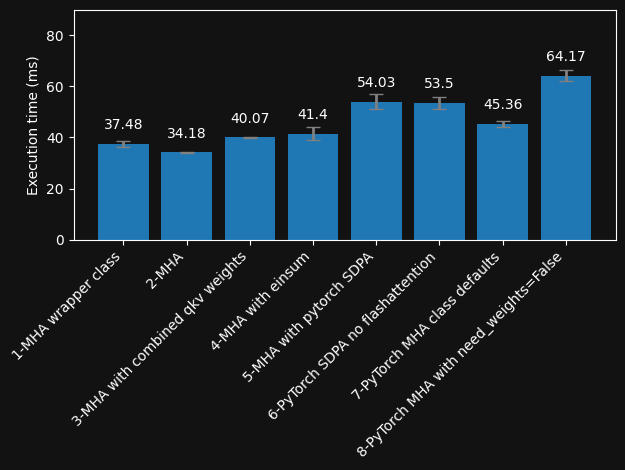

In [ ]:
functions={'1-MHA wrapper class':mha_wrapper,
           '2-MHA':mha,
           '3-MHA with combined qkv weights':mha_combined_qkv,
           '4-MHA with einsum':mha_einsum,
           '5-MHA with pytorch SDPA':mha_pytorch_scaled,
           '6-PyTorch SDPA no flashattention':mha_pytorch_sdpa_no_flash,
           '7-PyTorch MHA class defaults':mha_pytorch_class_default,
           '8-PyTorch MHA with need_weights=False':mha_pytorch_class_noweights}
plt.rcParams['figure.facecolor']='#121212'
plt.rcParams['axes.facecolor']='#121212'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['axes.labelcolor']='white'
plt.rcParams['text.color']='white'
plt.rcParams['xtick.color']='white'
plt.rcParams['ytick.color']='white'
plt.rcParams['grid.color']='#444444'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markersize']=8
def plot_execution_times(functions,execution_means,execution_stds,filename):
    fig,ax=plt.subplots()
    bars=ax.bar(functions.keys(),execution_means,yerr=execution_stds,capsize=5,error_kw={'ecolor':'grey'})
    plt.ylabel('Execution time (ms)')
    plt.xticks(rotation=45,
               ha='right')
    max_execution_time=max(execution_means)
    upper_ylim=max_execution_time+.4*max_execution_time
    plt.ylim(0,upper_ylim)
    for bar in bars:
        yval=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2,yval+(.05*upper_ylim),round(yval,2),ha='center',va='bottom')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
def time_pytorch_function(func,*input,num_repeats=1000):
    start=torch.mps.Event(enable_timing=True)
    end=torch.mps.Event(enable_timing=True)
    for _ in range(5):
        func(*input)
    torch.mps.synchronize()
    times=[]
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.mps.synchronize()
        times.append(start.elapsed_time(end))
    return np.mean(times),np.std(times)
execution_stats=[time_pytorch_function(fn,embeddings) for fn in functions.values()]
execution_means=[stat[0] for stat in execution_stats]
execution_stds=[stat[1] for stat in execution_stats]
plot_execution_times(functions,execution_means,execution_stds,filename='images/0-forward_only.pdf')

## Speed Comparison With Warmup (Forward, Backward Pass)

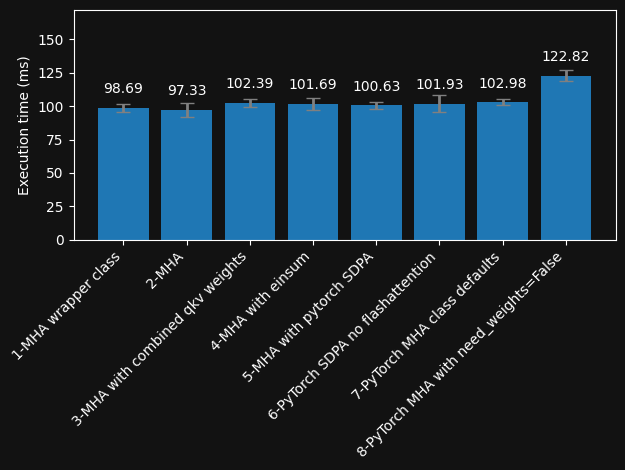

In [ ]:
def forward_backward(func,embeddings):
    if embeddings.grad is not None:
        embeddings.grad.zero_()
    output=func(embeddings)
    loss=output.sum()
    loss.backward()
def time_pytorch_function_forward_backward(func,*input,num_repeats=1000):
    start=torch.mps.Event(enable_timing=True)
    end=torch.mps.Event(enable_timing=True)
    for _ in range(5):
        forward_backward(func,*input)
    torch.mps.synchronize()
    times=[]
    for _ in range(num_repeats):
        start.record()
        forward_backward(func,*input)
        end.record()
        torch.mps.synchronize()
        times.append(start.elapsed_time(end))
    return np.mean(times),np.std(times)
execution_stats=[time_pytorch_function_forward_backward(fn,embeddings) for fn in functions.values()]
execution_means=[stat[0] for stat in execution_stats]
execution_stds=[stat[1] for stat in execution_stats]
plot_execution_times(functions,execution_means,execution_stds,filename='images/1-forward_backward.pdf')